# **NLP Project- Stock Market News Sentiment Analysis**

## Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing the necessary libraries**

In [ ]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 818.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 31.5 MB/s eta 0:00:00


In [ ]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# To build, tune, and evaluate ML models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## **Loading the dataset**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
stock_news = pd.read_csv("stock_news.csv")  # Read the CSV file named 'stock_news' into a pandas DataFrame named 'stock'.

In [ ]:
#Creating a copy of the dataset
stock = stock_news.copy()

## **Data Overview**

In [ ]:
# Displaying the first few rows of the dataset
stock.head(5)  # Show the first 5 rows of the data

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [ ]:
# Understanding the shape of the dataset
stock.shape

(349, 8)

* There are a total of 349 records with 8 attributes each.

In [ ]:
# Checking the data types of the columns
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


- Let's convert the Date column to pandas `datetime` type.

In [ ]:
stock['Date'] = pd.to_datetime(stock['Date'])  # Convert the 'Date' column in the 'stocks' DataFrame to datetime format.

### Checking the statistical summary

In [ ]:
stock.describe()

,Date,Open,High,Low,Close,Volume,Label
count,349,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,2019-02-16 16:05:30.085959936,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
min,2019-01-02 00:00:00,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,2019-01-14 00:00:00,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,2019-02-05 00:00:00,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,2019-03-22 00:00:00,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,2019-04-30 00:00:00,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000
std,NaN,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119


* The stock prices ranges from ~\$36 to ~\$67.

* The mean volume of the stocks is 128,948,200, indicating that on a certain day, ~130 million stocks were traded

* The data ranges from 2019-01-02 to 2019-04-30, which is roughly a span of four months.

### Checking the duplicate values

In [ ]:
stock.duplicated().sum()

0

* There are no duplicate values.

### Checking for missing values

In [ ]:
stock.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


* There are no missing values.

## **Exploratory Data Analysis**

### Univariate Analysis

#### Observations on Label

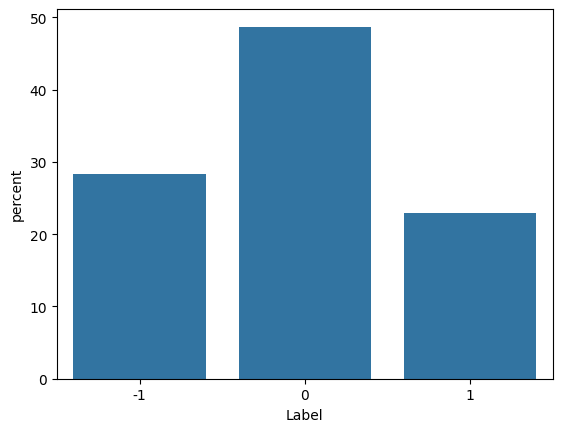

In [ ]:
sns.countplot(data=stock, x='Label', stat="percent");

* The dataset is slightly imbalanced for the sentiment polarities.
* There is more news content with neutral polarity compared to other types.

#### Density Plot of Price (Open, High, Low, Close)

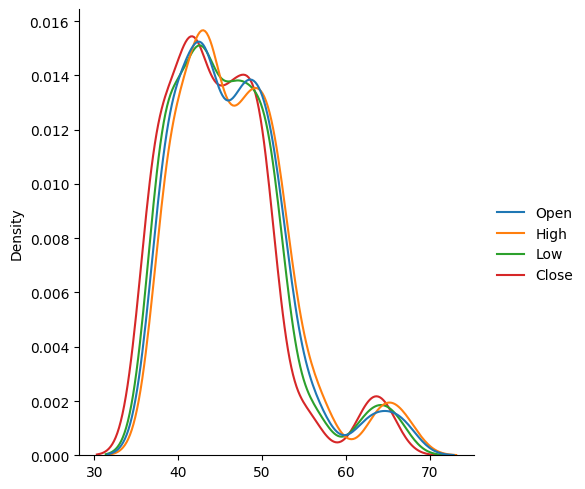

In [ ]:
# Plot KDE for the 'Open', 'High', 'Low', 'Close' columns of the 'stock' DataFrame.
sns.displot(data=stock[['Open','High','Low','Close']], kind='kde', palette="tab10");  # Create a KDE plot with a color palette.

* The distributions of the prices are quite similar, with the high price showing a slight variation than the others.

#### Observations on Volume

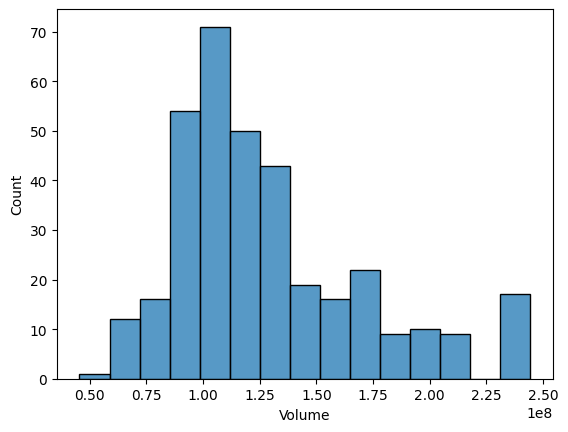

In [ ]:
sns.histplot(stock, x='Volume');

* In a large portion of the time considered, 80 to 175 million shares of the stock were traded, with occasional days where the volume rose to more than 200 million.

#### Observations on News Length

In [ ]:
#Calculating the total number of words present in the news content.
stock['news_len'] = stock['News'].apply(lambda x: len(x.split(' ')))
stock['news_len'].describe()

,news_len
count,349.000000
mean,49.312321
std,5.727770
min,19.000000
25%,46.000000
50%,50.000000
75%,53.000000
max,61.000000


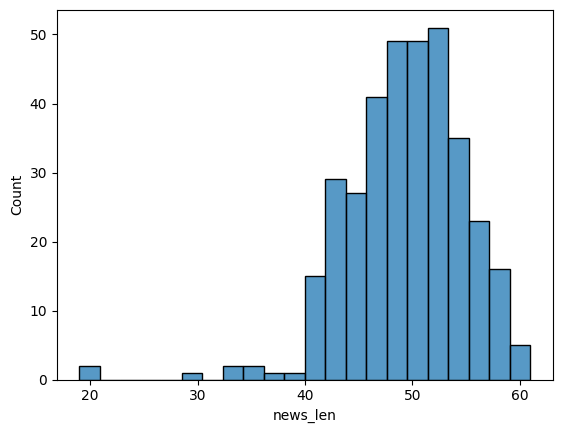

In [ ]:
sns.histplot(data=stock,x='news_len');

* Most of the news have between 40-60 words, with an average of 50 words
    * The shortest news has 19 words

* This indicates that these are likely to be news summaries rather than the actual news content itself.

### Bivariate Analysis

#### Correlation

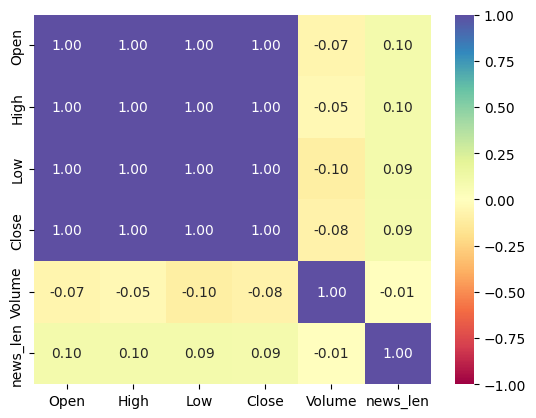

In [ ]:
cols = ['Open','High','Low','Close','Volume','news_len']
sns.heatmap(
    stock[cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

* The prices are all perfectly correlated.
    * This might be due to the minimum variation between the different prices.

* There is a negative correlation, albeit very low, between volume and prices.
    * This might be due to selling pressure during periods of negative sentiment.

#### Label vs Price (Open, High, Low, Close)

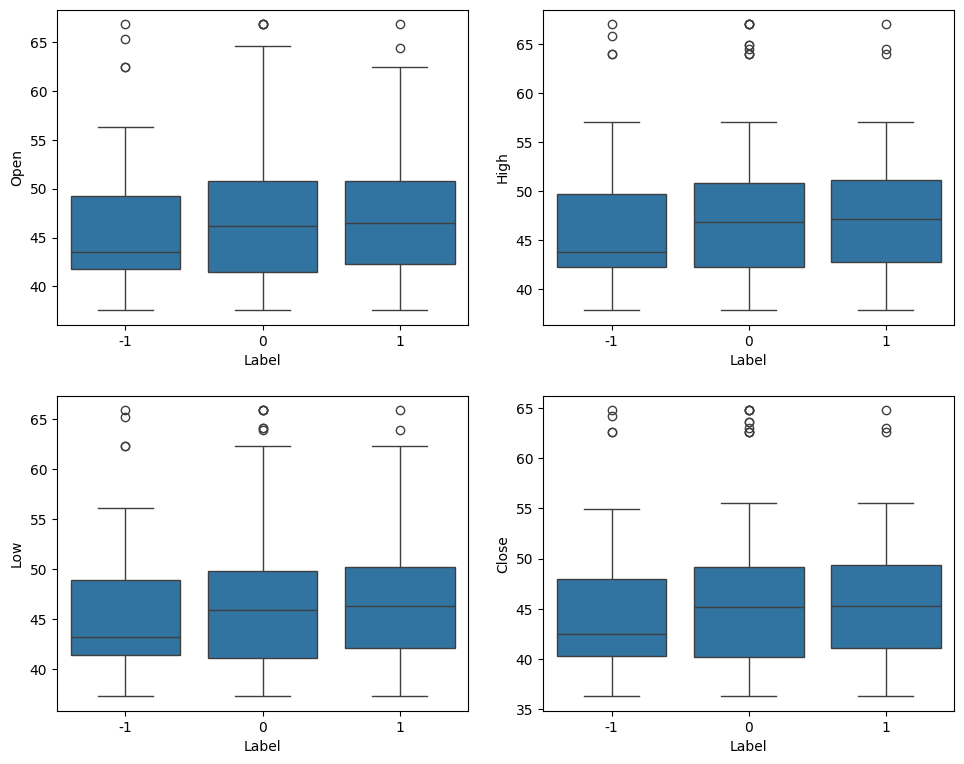

In [ ]:
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=stock, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

* The median for all prices is lower for negative sentiment polarity news than other sentiment polarities, clearly indicating that negative news drags the stock price lower as investors might be selling off their shares in response to the negative news.

* The higher upper whisker for the open price in neutral sentiment news compared to positive sentiment indicates more variability in how the market opens when neutral news is encountered.
    * This could be due to different people interpreting the news differently, leading to a wider range of opening prices.

#### Label vs Volume

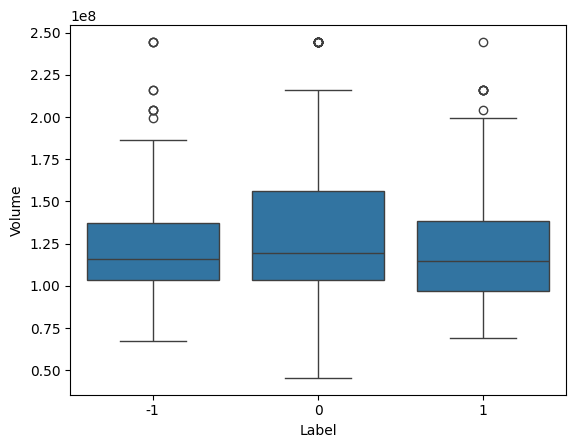

In [ ]:
sns.boxplot(
    data=stock, x="Label", y="Volume"
);

* The median trading volume for the stock is approximately the same across all sentiment polarities.
* The volumes for neutral sentiment news have a wider spread, indicating potential uncertainty among investors due to varied interpretations, leading to varied reactions.

#### Date vs Price (Open, High, Low, Close)

- The data is at the level of news, and we might have more than one news in a day
- However, the prices are at daily level
- So, we can aggregate the data at a daily level by taking the mean of the attributes

In [ ]:
stock_daily = stock.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()  # Group the 'stocks' DataFrame by the 'Date' column

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,41.740002,42.244999,41.482498,40.246914,130672400.0
2019-01-03,43.570000,43.787498,43.222500,42.470604,103544800.0
2019-01-04,47.910000,47.919998,47.095001,46.419842,111448000.0
2019-01-07,50.792500,51.122501,50.162498,49.110790,109012000.0
2019-01-08,53.474998,54.507500,51.685001,50.787209,216071600.0


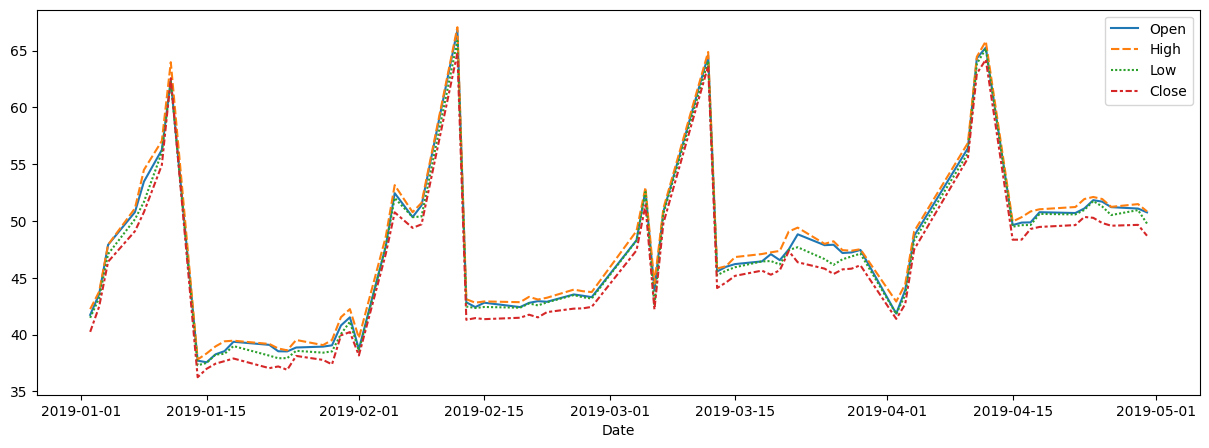

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(stock_daily.drop('Volume', axis=1));

* We can observe a seasonal trend in the prices - a repetitive pattern every month.
* The stock price has gradually increased over time from ~\$40 to ~\$50 in the period for which the data is available.

#### Volume vs Close Price

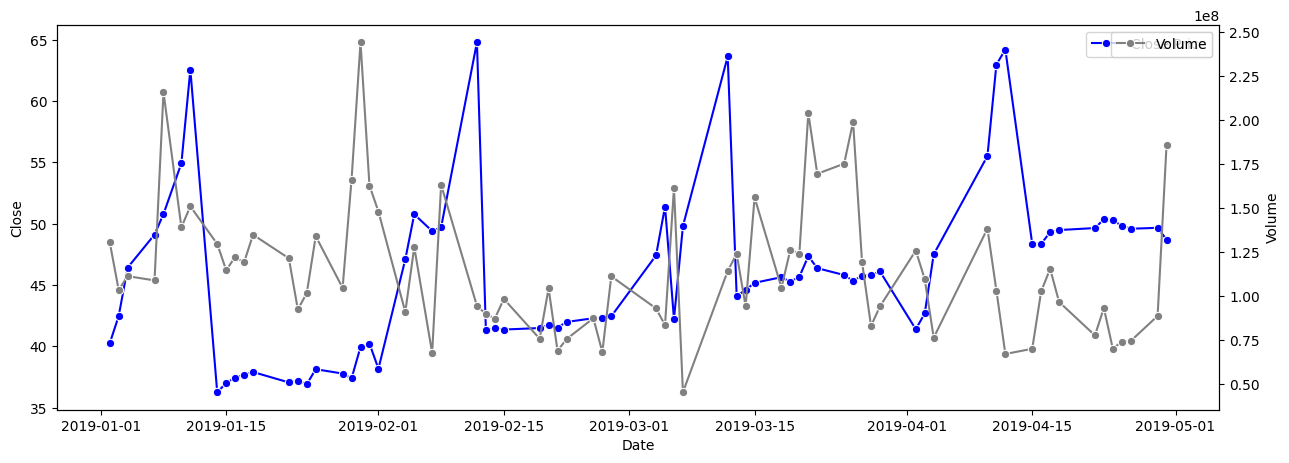

In [ ]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15,5))

# Lineplot on primary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Lineplot on secondary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));

- There is no specific pattern here
    - There have been periods where the price decreased with increasing volumes
    - There have been periods where the price increased with increasing volumes

## **Data Preprocessing**

In [ ]:
stock['Date'].describe()

,Date
count,349
mean,2019-02-16 16:05:30.085959936
min,2019-01-02 00:00:00
25%,2019-01-14 00:00:00
50%,2019-02-05 00:00:00
75%,2019-03-22 00:00:00
max,2019-04-30 00:00:00


* We see that 75% of the data is till the third week of March 2019.
* We'll take the data till the end of March 2019 for training, and divide the April 2019 data into validation and test sets.

### Train-test-validation Split

In [ ]:
X_train = stock[stock['Date'] < '2019-04-01'].reset_index()
X_val = stock[(stock['Date'] >= '2019-04-01') & (stock['Date'] < '2019-04-16')].reset_index()
X_test = stock[stock['Date'] >= '2019-04-16'].reset_index()

In [ ]:
y_train = X_train['Label'].copy()
y_val = X_val['Label'].copy()
y_test = X_test['Label'].copy()

In [ ]:
print("Train data shape",X_train.shape)
print("Validation data shape",X_val.shape)
print("Test data shape ",X_test.shape)

print("Train label shape",y_train.shape)
print("Validation label shape",y_val.shape)
print("Test label shape ",y_test.shape)

Train data shape (286, 10)
Validation data shape (21, 10)
Test data shape  (42, 10)
Train label shape (286,)
Validation label shape (21,)
Test label shape  (42,)


In [ ]:
y_train.value_counts(normalize=True)

,proportion
Label,
0,0.482517
-1,0.286713
1,0.230769


In [ ]:
y_val.value_counts(normalize=True)

,proportion
Label,
0,0.571429
1,0.238095
-1,0.190476


In [ ]:
y_test.value_counts(normalize=True)

,proportion
Label,
0,0.476190
-1,0.309524
1,0.214286


## **Word Embeddings**

### Word2Vec

In [ ]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in stock['News'].values]

In [ ]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 4682


Let's check out a few word embeddings obtained using the model.

In [ ]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([ 4.89973323e-03,  4.23764065e-02,  7.14861415e-03,  2.30925307e-02,
       -5.02910744e-03, -4.93982211e-02,  3.54974642e-02,  8.40451866e-02,
        9.16833431e-03, -1.50819188e-02,  1.27967214e-02, -2.36852095e-02,
        1.49972446e-04,  1.20403133e-02, -2.85706893e-02, -2.46955529e-02,
        2.31663920e-02, -1.09419124e-02, -3.18892044e-03, -1.42406765e-02,
       -2.86114179e-02,  3.86189646e-03,  3.72058228e-02,  8.06310680e-03,
        1.50912376e-02,  6.01229630e-03, -4.51860353e-02,  5.06948354e-03,
       -1.67591982e-02, -3.65566239e-02,  1.50054963e-02, -2.25861035e-02,
        2.70232232e-03, -3.47209931e-03, -6.47016242e-03,  1.47710824e-02,
        1.78557765e-02, -3.81438136e-02,  5.84462774e-04, -1.10750757e-02,
       -1.52218062e-02, -5.64437301e-04, -1.93203555e-03, -2.49052756e-02,
        1.62839554e-02,  3.91126126e-02, -3.31135670e-04,  9.74126067e-03,
       -2.01458018e-03,  2.64703725e-02,  1.82790887e-02,  3.69458017e-03,
       -1.73518974e-02,  

In [ ]:
# Checking the word embedding of a random word
word = "economy"
model_W2V.wv[word]

array([ 2.6811804e-03,  6.1461357e-03,  2.6973087e-04,  3.4178079e-03,
       -2.7452859e-03, -8.3938176e-03,  8.5883038e-03,  1.5563592e-02,
        3.4080443e-04, -1.3509747e-03,  2.6242812e-03, -4.7597131e-03,
        5.9595390e-04,  2.0201569e-03, -4.7357245e-03, -3.2147949e-03,
        2.6000843e-03, -3.1034395e-03, -7.4674527e-04, -4.0000407e-03,
       -1.4745883e-03,  1.8324926e-03,  5.1875627e-03,  2.3941246e-03,
        4.6369983e-03,  1.5944744e-03, -4.6911021e-03, -1.5312505e-03,
       -2.2419766e-03, -5.8787409e-03,  3.1253374e-03, -2.2123295e-03,
        3.0455056e-03, -1.8128994e-03, -7.1875787e-05,  3.2141688e-03,
        1.5796399e-03, -2.9235946e-03,  3.9087879e-04, -1.8799189e-03,
       -4.5872736e-03,  6.6681107e-04,  1.3177287e-03, -4.9598478e-03,
       -1.0140899e-03,  6.6243364e-03, -1.7459810e-03,  4.8864861e-03,
       -2.8653687e-03,  5.7534715e-03,  3.8370374e-04, -3.3705478e-04,
       -2.4298190e-03,  1.0467436e-03, -2.8302455e-03,  5.1261419e-03,
      

In [ ]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [ ]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_wv = pd.DataFrame(X_train['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  0.6878888607025146


In [ ]:
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(286, 300) (21, 300) (42, 300)


### GloVe

In [ ]:
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


Let's check out a few word embeddings.

In [ ]:
# Checking the word embedding of a random word
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [ ]:
# Checking the word embedding of a random word
word = "economy"
glove_model[word]

array([-0.19382  ,  1.017    ,  1.076    ,  0.02954  , -0.39192  ,
       -1.3891   , -0.87873  , -0.63162  ,  0.9643   , -0.43035  ,
       -0.34868  ,  0.22736  , -0.40296  ,  0.15641  , -0.16813  ,
       -0.15343  , -0.15799  , -0.27612  ,  0.18088  , -0.28386  ,
        0.49847  ,  0.29864  ,  0.32353  ,  0.18108  , -0.59623  ,
       -0.54165  , -0.70019  , -0.64956  , -0.69063  ,  0.18084  ,
       -0.38581  ,  0.56086  , -0.40313  , -0.38777  , -0.70615  ,
        0.20657  ,  0.34171  , -0.23393  , -0.35882  , -0.2201   ,
       -0.76182  , -1.2047   ,  0.4339   ,  1.1656   ,  0.1836   ,
       -0.21601  ,  0.93198  , -0.059616 , -0.11624  , -1.3259   ,
       -0.79772  , -0.0074957, -0.0889   ,  1.4749   ,  0.31157  ,
       -2.2952   , -0.058351 ,  0.39353  ,  1.4983   ,  0.74023  ,
       -0.20109  ,  0.098124 , -0.73081  , -0.32294  ,  0.16703  ,
        0.87431  , -0.041624 , -0.51022  ,  1.0737   , -0.4257   ,
        1.0581   ,  0.19859  , -0.60087  , -0.33906  ,  0.6024

In [ ]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [ ]:
vec_size=100

In [ ]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_gl = pd.DataFrame(X_train['News'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_gl = pd.DataFrame(X_val['News'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_gl = pd.DataFrame(X_test['News'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  38.90265703201294


In [ ]:
print(X_train_gl.shape, X_test_gl.shape)

(286, 100) (42, 100)


### Sentence Transformer

#### Defining the model

In [ ]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Encoding the dataset

In [ ]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# encoding the dataset
start = time.time()

X_train_st = model.encode(X_train['News'].values, show_progress_bar=True, device=device)
X_val_st = model.encode(X_val['News'].values, show_progress_bar=True, device=device)
X_test_st = model.encode(X_test['News'].values, show_progress_bar=True, device=device)

end = time.time()
print("Time taken ",(end-start))

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken  21.895453453063965


In [ ]:
print(X_train_st.shape, X_val_st.shape, X_test_st.shape)

(286, 384) (21, 384) (42, 384)


- Each news content has been converted to a 384-dimensional vector.

## **Sentiment Analysis**

### Model Evaluation Criterion

- In stock analysis, where the accuracy of classifying news into positive, negative, or neutral categories directly impacts decision-making, the **F1 Score** is the best metric.
- It balances precision and recall, which helps ensure that your model is both accurate and comprehensive. Precision minimizes false positives, so you don’t overreact to neutral news as negative, while recall ensures you capture all relevant news, avoiding missed risks.
- This balance is crucial, especially when the news distribution may be imbalanced, helping you make better-informed stock decisions.

### Utility Functions

In [ ]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [ ]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

### Base Model - Word2Vec

In [ ]:
# Building the model
base_wv = GradientBoostingClassifier(random_state = 42)

# Fitting on train data
base_wv.fit(X_train_wv, y_train)

GradientBoostingClassifier(random_state=42)

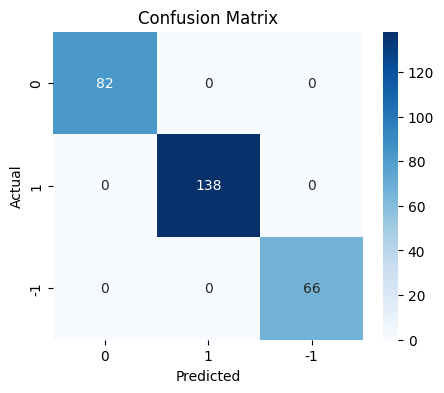

In [ ]:
plot_confusion_matrix(base_wv,X_train_wv,y_train)

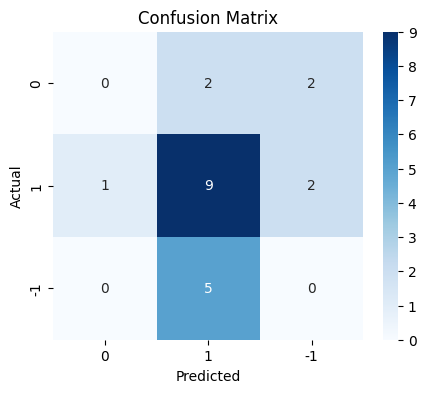

In [ ]:
plot_confusion_matrix(base_wv,X_val_wv,y_val)

In [ ]:
#Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
#Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.428571  0.428571   0.321429  0.367347


* The model is highly overfitting, as there is a significant difference between its performance on the training set and the validation set.

### Base Model - GloVe

In [ ]:
# Building the model
base_gl = GradientBoostingClassifier(random_state = 42)

# Fitting on train data
base_gl.fit(X_train_gl, y_train)

GradientBoostingClassifier(random_state=42)

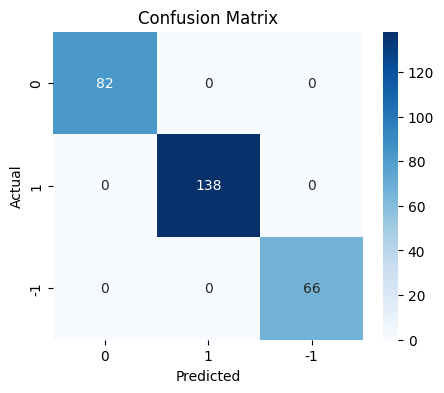

In [ ]:
plot_confusion_matrix(base_gl,X_train_gl,y_train)

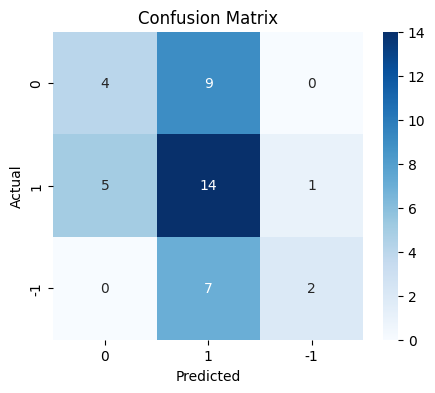

In [ ]:
plot_confusion_matrix(base_gl,X_test_gl,y_test)

In [ ]:
#Calculating different metrics on training data
base_train_gl=model_performance_classification_sklearn(base_gl,X_train_gl,y_train)
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
#Calculating different metrics on validation data
base_val_gl = model_performance_classification_sklearn(base_gl,X_val_gl,y_val)
print("Validation performance:\n",base_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.380952  0.380952   0.326531  0.351648


* The model is highly overfitting, as there is a significant difference between its performance on the training set and the validation set.

### Base Model - Sentence Transformer

In [ ]:
# Building the model
base_st = GradientBoostingClassifier(random_state = 42)

# Fitting on train data
base_st.fit(X_train_st, y_train)

GradientBoostingClassifier(random_state=42)

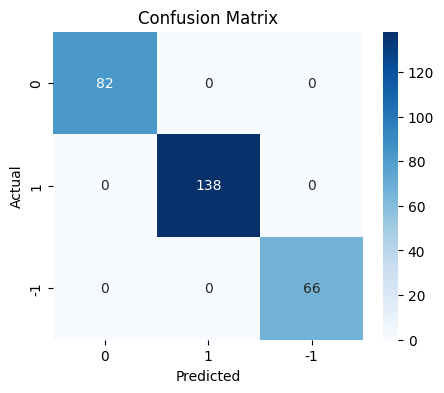

In [ ]:
plot_confusion_matrix(base_st, X_train_st, y_train)

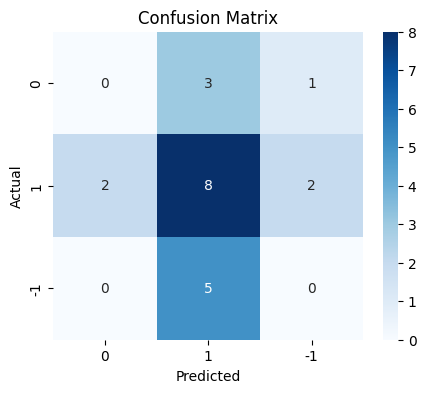

In [ ]:
plot_confusion_matrix(base_st, X_val_st, y_val)

In [ ]:
#Calculating different metrics on training data
base_train_st=model_performance_classification_sklearn(base_st, X_train_st, y_train)
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
#Calculating different metrics on validation data
base_val_st = model_performance_classification_sklearn(base_st,X_val_st,y_val)
print("Validation performance:\n",base_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.380952  0.380952   0.285714  0.326531


* The model is highly overfitting, as there is a significant difference between its performance on the training set and the validation set.

### Tuned Model - Word2Vec

In [ ]:
start = time.time()

# Choose the type of classifier.
tuned_wv = GradientBoostingClassifier(random_state = 42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

Time taken  655.9046559333801


In [ ]:
# Fit the best algorithm to the data.
tuned_wv.fit(X_train_wv, y_train)

GradientBoostingClassifier(max_features=0.2, min_samples_split=9,
                           random_state=42)

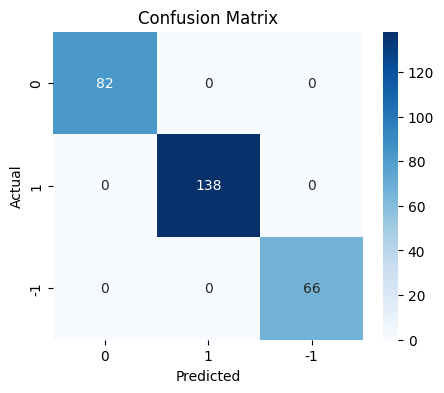

In [ ]:
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

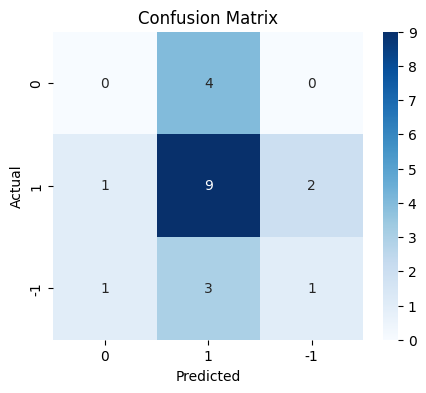

In [ ]:
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

In [ ]:
#Calculating different metrics on training data
tuned_train_wv=model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n",tuned_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
#Calculating different metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619   0.400794  0.426871


* The model still overfits the data.

### Tuned Model - GloVe

In [ ]:
start = time.time()

# Choose the type of classifier.
tuned_gl = GradientBoostingClassifier(random_state = 42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_gl, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_gl, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

Time taken  330.9398362636566


In [ ]:
# Fit the best algorithm to the data.
tuned_gl.fit(X_train_gl, y_train)

GradientBoostingClassifier(max_features='log2', min_samples_split=9,
                           random_state=42)

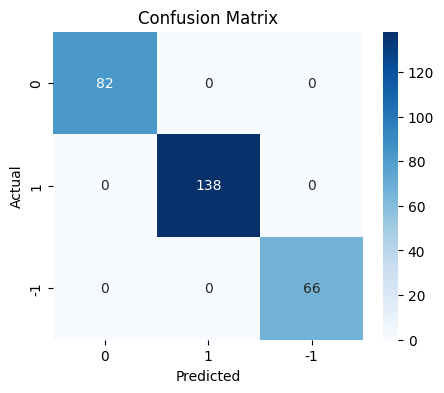

In [ ]:
plot_confusion_matrix(tuned_gl,X_train_gl,y_train)

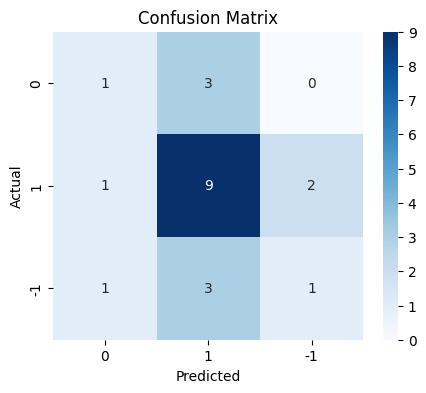

In [ ]:
plot_confusion_matrix(tuned_gl,X_val_gl,y_val)

In [ ]:
#Calculating different metrics on training data
tuned_train_gl=model_performance_classification_sklearn(tuned_gl,X_train_gl,y_train)
print("Training performance:\n",tuned_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
#Calculating different metrics on validation data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl,X_val_gl,y_val)
print("Validation performance:\n",tuned_val_gl)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.52381  0.52381   0.485714  0.494898


* The model still overfits the data.

### Tuned Model - Sentence Transformer

In [ ]:
start = time.time()

# Choose the type of classifier.
tuned_st = GradientBoostingClassifier(random_state = 42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_st, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_st, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

Time taken  803.5205283164978


In [ ]:
# Fit the best algorithm to the data.
tuned_st.fit(X_train_st, y_train)

GradientBoostingClassifier(max_features='sqrt', min_samples_split=5,
                           random_state=42)

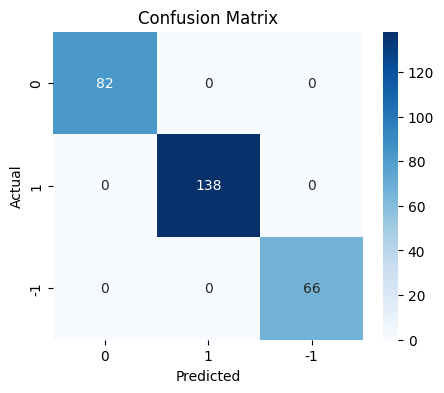

In [ ]:
plot_confusion_matrix(tuned_st,X_train_st,y_train)

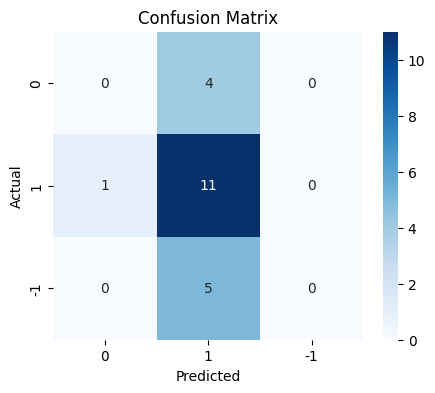

In [ ]:
plot_confusion_matrix(tuned_st,X_val_st,y_val)

In [ ]:
#Calculating different metrics on training data
tuned_train_st=model_performance_classification_sklearn(tuned_st,X_train_st,y_train)
print("Training performance:\n",tuned_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
#Calculating different metrics on validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st,X_val_st,y_val)
print("Validation performance:\n",tuned_val_st)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.52381  0.52381   0.314286  0.392857


* The model still overfits the data.

### Model Performance Summary and Final Model Selection

In [ ]:
#training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,1.0,1.0,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0,1.0,1.0
F1,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
#validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.428571,0.380952,0.380952,0.476190,0.523810,0.523810
Recall,0.428571,0.380952,0.380952,0.476190,0.523810,0.523810
Precision,0.321429,0.326531,0.285714,0.400794,0.485714,0.314286
F1,0.367347,0.351648,0.326531,0.426871,0.494898,0.392857


- All the models overfit the data.
- Amongst the models built, the ML model built on the GloVe-encoded data exhibits the highest f1 score.
- We'll choose this as our final model.

### Model Performance Check on Test Data

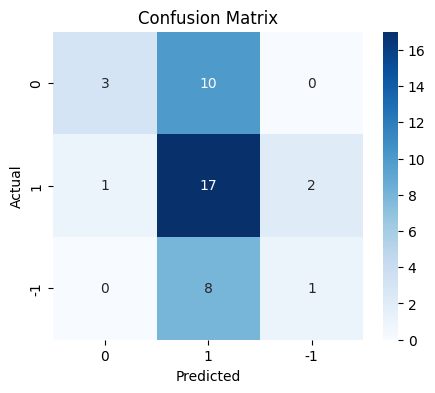

In [ ]:
plot_confusion_matrix(tuned_gl,X_test_gl,y_test)

In [ ]:
#Calculating different metrics on training data
tuned_test_gl = model_performance_classification_sklearn(tuned_gl,X_test_gl,y_test)
print("Test performance:\n",tuned_test_gl)

Test performance:
    Accuracy  Recall  Precision       F1
0       0.5     0.5   0.534864  0.43933


## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

### Installing and Importing the necessary libraries

In [ ]:
# Installation for GPU llama-cpp-python
#uncomment and run the following code in case GPU is being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

# Installation for CPU llama-cpp-python
#uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 84.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 178.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 128.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 74.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 0.32.1 requires numpy<2.0.0,>=1.17, but you have numpy 2.1.0 which is incompatible.
albucore 0.0.13 requires numpy<2,>=1.24.4, but you have numpy 2.1.0 which is incompatible.
arviz 0.18.0 requires numpy<2.0,>=1.23.0, but you have numpy 2.1.0 which is incompatible.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.23, but you have numpy 2.1.0 which is incompatible.


In [ ]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

### Loading the data

In [ ]:
stock_news = pd.read_csv('stock_news.csv')

In [ ]:
data = stock_news.copy()

### Loading the model

In [ ]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [ ]:
#uncomment the below snippet of code if the runtime is connected to GPU.
llm = Llama(
    model_path=model_path,
    n_gpu_layers=100,
    n_ctx=4500,
)

#uncomment the below snippet of code if the runtime is connected to CPU.
# llm = Llama(
#     model_path=model_path,
#     n_ctx=4500,
# )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


### Aggregating the data weekly

In [ ]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
# Aggregate the grouped data on a weekly basis:
# concatenate 'content' values into a single string separated by ' || '.
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [ ]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [ ]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

### Summarization

#### Defining the response function

In [ ]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=400,
      temperature=0.05,
      top_p=0.9,
      top_k=40,
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

#### Utility Function

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

#### Checking the model output on a sample

In [ ]:
news = data_1.loc[0, 'News']

In [ ]:
print(len(news.split(' ')))
news

2611


' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [ ]:
prompt = """
    You're an expert in stock market news summarization.
    You'll be provided with multiple news articles, each sepearated by ' || '.
    Read through each of the news articles and extract the top three positive and negative aspects that could potentially impact the stock's performance.
    Consider factors such as market trends, company announcements, economic indicators, and any other relevant information.
    Return in a JSON format as follows:
    {"Postive Aspects" : [point_1, point_2, point_3], "Negative Aspects" : [point_1, point_2, point_3]}
    Return only the JSON output and nothing else.
"""

In [ ]:
news = data['News'].iloc[0]

In [ ]:
%%time
summary = response_mistral_1(prompt, news)

In [ ]:
summary

'{"Positive Aspects" : ["Apple\'s announcement of plans to offer premium video channels on The Roku Channel", "The Chinese central bank\'s fifth reduction in the required reserve ratio for banks, freeing up approximately 116.5 billion yuan for new lending"],\n        "Negative Aspects" : ["Apple\'s Q1 revenue guidance cut due to weaker demand in China and fewer iPhone upgrades", "Concerns about a global economic slowdown following weak economic data from China and Europe, as well as the partial U.S. government shutdown"]}\n     \n     Note: The positive aspects mentioned are not directly related to Apple\'s revenue warning but are news items that could potentially have a positive impact on the stock market or specific companies mentioned in the articles. Similarly, the negative aspects mentioned are directly related to Apple\'s revenue warning and its impact on the stock market and related suppliers.'

#### Checking the model output on the weekly data

In [ ]:
%%time
data_1['Key Events'] = data_1['News'].progress_apply(lambda x: response_mistral_1(prompt,x))

100%|██████████| 18/18 [04:13<00:00, 14.06s/it]

CPU times: user 3min 14s, sys: 30.4 s, total: 3min 45s
Wall time: 4min 13s


In [ ]:
data_1['Key Events'].head(5)

,Key Events
0,"{""Positive Aspects"" : [""Apple's announcement o..."
1,"{""Positive Aspects"" : [""Sprint and Samsung pla..."
2,"{""Positive Aspects"" : [\n ""Apple's part..."
3,"{""Positive Aspects"" : [\n ""IBM reported..."
4,"{""Positive Aspects"" : [""Apple reported stronge..."


#### Formatting the model output

In [ ]:
data_1['model_response_parsed'] = data_1['Key Events'].apply(extract_json_data)
data_1.head()

,Date,News,Key Events,model_response_parsed
0,2019-01-06,The tech sector experienced a significant dec...,"{""Positive Aspects"" : [""Apple's announcement o...",{'Positive Aspects': ['Apple's announcement of...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,"{""Positive Aspects"" : [""Sprint and Samsung pla...",{'Positive Aspects': ['Sprint and Samsung plan...
2,2019-01-20,The U.S. stock market declined on Monday as c...,"{""Positive Aspects"" : [\n ""Apple's part...",{'Positive Aspects': ['Apple's partnership wit...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...","{""Positive Aspects"" : [\n ""IBM reported...",{'Positive Aspects': ['IBM reported better-tha...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,"{""Positive Aspects"" : [""Apple reported stronge...",{'Positive Aspects': ['Apple reported stronger...


In [ ]:
model_response_parsed = pd.json_normalize(data_1['model_response_parsed'])
model_response_parsed.head()

,Positive Aspects,Negative Aspects
0,[Apple's announcement of plans to offer premiu...,[Apple's Q1 revenue warning leading to signifi...
1,[Sprint and Samsung planning to release 5G sma...,[Geely forecasting flat sales for 2019 due to ...
2,[Apple's partnership with TD Ameritrade enabli...,[Global economic slowdown concerns following w...
3,[IBM reported better-than-expected earnings an...,[Swiss National Bank governor emphasized the n...
4,[Apple reported stronger-than-expected earning...,[Caterpillar Inc reported lower-than-expected ...


In [ ]:
final_output = pd.concat([data_1.reset_index(drop=True),model_response_parsed],axis=1)
final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

final_output.head()

,Week End Date,News,Week Positive Events,Week Negative Events
0,2019-01-06,The tech sector experienced a significant dec...,[Apple's announcement of plans to offer premiu...,[Apple's Q1 revenue warning leading to signifi...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,[Sprint and Samsung planning to release 5G sma...,[Geely forecasting flat sales for 2019 due to ...
2,2019-01-20,The U.S. stock market declined on Monday as c...,[Apple's partnership with TD Ameritrade enabli...,[Global economic slowdown concerns following w...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...",[IBM reported better-than-expected earnings an...,[Swiss National Bank governor emphasized the n...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,[Apple reported stronger-than-expected earning...,[Caterpillar Inc reported lower-than-expected ...


## **Conclusions and Recommendations**

* The daily opening, high, low, and closing prices of the stock exhibit similar distributions individually, when compared across different sentiment polarities, and negative sentiment news resulted in a lower value for each price.

* The minimum variation also resulted in the prices exhibiting perfect correlation amongst them, while exhibiting a very low negative correlation with volume, which might be due to selling pressure during periods of negative sentiment.

* The stock price gradually increased over time from ~\$40 to ~\$50 in the period for which the data is available while exhibiting a monthly trend.

* We predicted the sentiment of market news by encoding them via different methods and using an ML model.

* The models (gradient boosting machine) largely overfit the data, with only one of the models, after tuning, yielding comparatively better performance than the others.
    * It is recommended to try out other models to try and improve the performance.

* Due to the complexity of the language used in news articles, ML models might find it difficult to identify clear patterns in them. As such, it is recommended to collect more data to allow the model to better understand patterns and context from the news content.
    * The predominance of neutral news also suggests a cautious market sentiment in this period. As such, a wider period should be considered for data collection to ensure volume and diversity in news sentiment polarities.

* The weekly news summarization was done by an LLM (Mistral 7B) and it did a good job of identifying the key positive and negative events from the week.
    * This will help a financial analyst make informed decisions when developing trading strategies for the future.
    * One can explore combining news sentiments with daily prices and volumes to help the LLM better identify the key positive and negative event in the week.

* Integrating real-time sentiment analysis systems can allow financial analysts to make informed decisions and quickly respond to market sentiment changes
to optimize investment strategies.

* One can explore combining news sentiments with technical and fundamental indicators of the stock and introduce data of other similar stocks for a more comprehensive market analysis.